# SVM Tunnel Classification Project

This notebook performs multiclass classification on tunnel data using Support Vector Machine (SVM) with advanced techniques including:
- SMOTE for class balancing
- RandomizedSearchCV for hyperparameter tuning
- Comprehensive evaluation with ROC, PR curves, and feature importance analysis

In [1]:
import numpy as np
import pandas as pd

## 1. Import Libraries

In [2]:
df = pd.read_csv("tunnel.csv")

## 2. Load and Explore Data


In [4]:
df.head()

,No,D (m),H(m),Q,K(MPa),ε (%),Class
0,1,6.0,150.0,0.4,26.19,0.42,1
1,2,6.0,200.0,0.4,20.00,0.75,1
2,3,5.8,350.0,0.5,2.53,7.90,3
3,4,4.8,225.0,3.6,1000.00,0.06,1
4,5,4.8,340.0,1.8,500.00,0.40,1


In [5]:
df.shape

(117, 7)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      117 non-null    int64  
 1   D (m)   117 non-null    float64
 2   H(m)    117 non-null    float64
 3   Q       117 non-null    float64
 4   K(MPa)  117 non-null    float64
 5   ε (%)   117 non-null    float64
 6   Class   117 non-null    int64  
dtypes: float64(5), int64(2)
memory usage: 6.5 KB


In [8]:
df.describe()

,No,D (m),H(m),Q,K(MPa),ε (%),Class
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000
mean,59.000000,6.351282,378.924786,1.421615,374.410171,3.925214,2.230769
std,33.919021,2.354366,207.212509,8.761644,711.304516,5.465696,0.864876
min,1.000000,2.500000,52.000000,0.001000,0.000000,0.000000,1.000000
25%,30.000000,4.600000,220.000000,0.020000,9.800000,0.750000,1.000000
50%,59.000000,5.800000,312.000000,0.060000,26.190000,2.500000,3.000000
75%,88.000000,8.700000,580.000000,0.400000,648.000000,4.500000,3.000000
max,117.000000,13.000000,850.000000,93.500000,5324.000000,36.730000,3.000000


In [3]:
df = df.drop(columns=["No"])

## 3. Data Preprocessing

In [10]:
df.isnull().sum()

D (m)     0
H(m)      0
Q         0
K(MPa)    0
ε (%)     0
Class     0
dtype: int64

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

## 4. Exploratory Data Analysis (EDA)

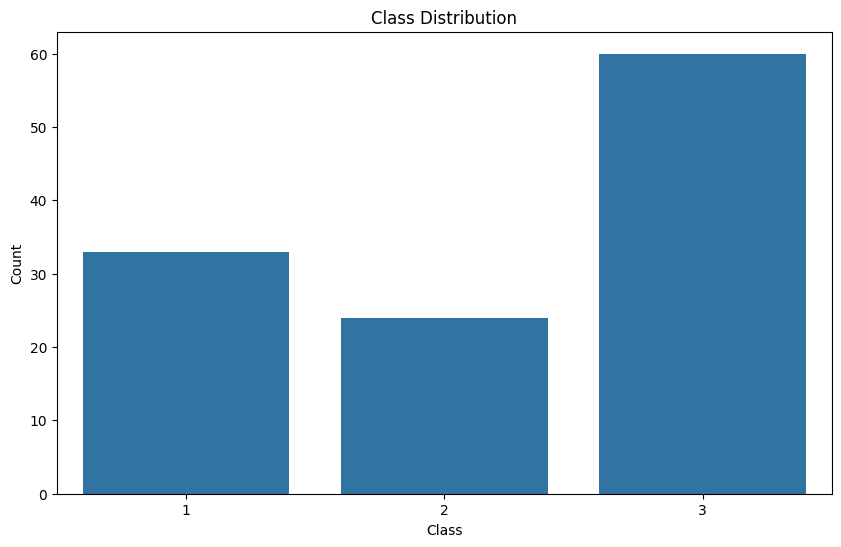

In [12]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count') 
plt.show()

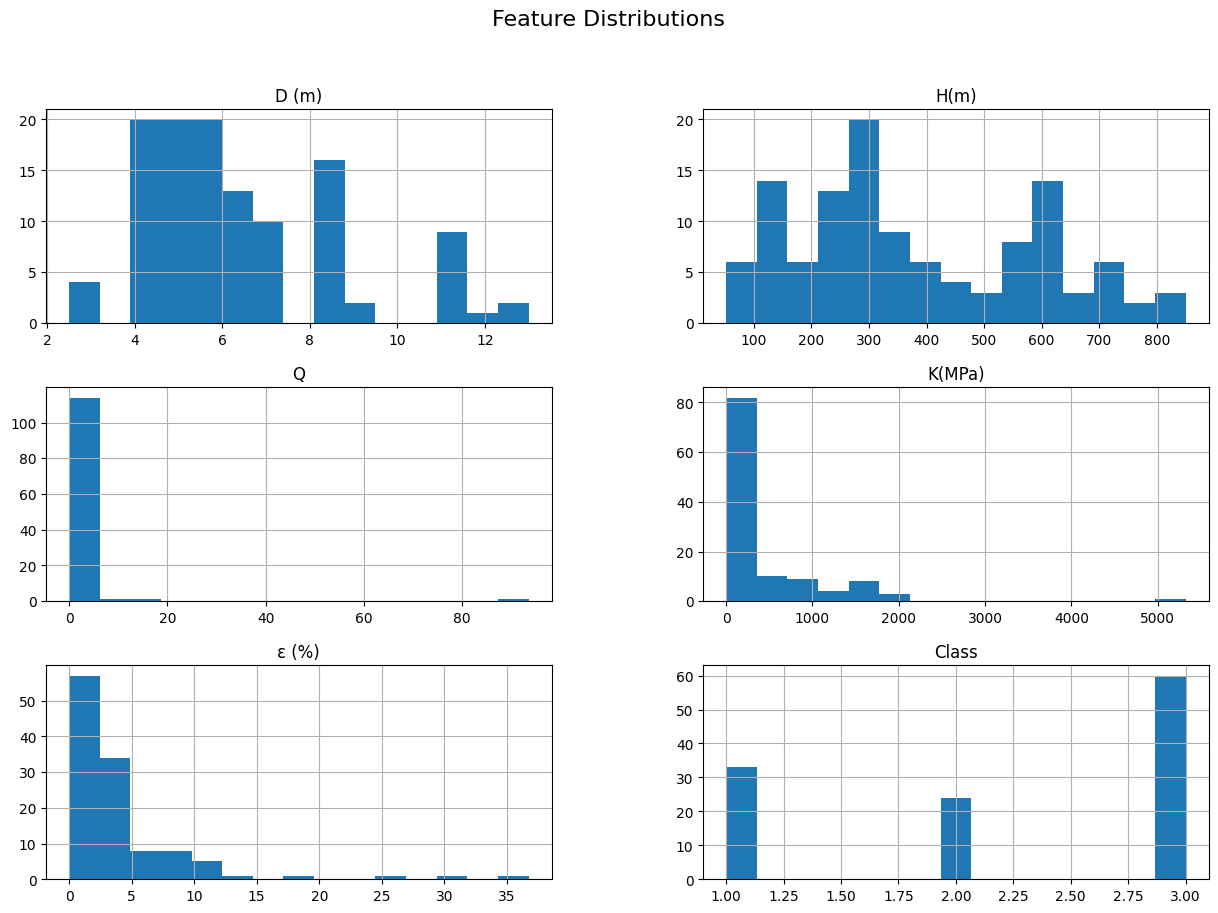

In [13]:
df.hist(bins=15, figsize=(15, 10))
plt.suptitle('Feature Distributions', fontsize=16)
plt.show()

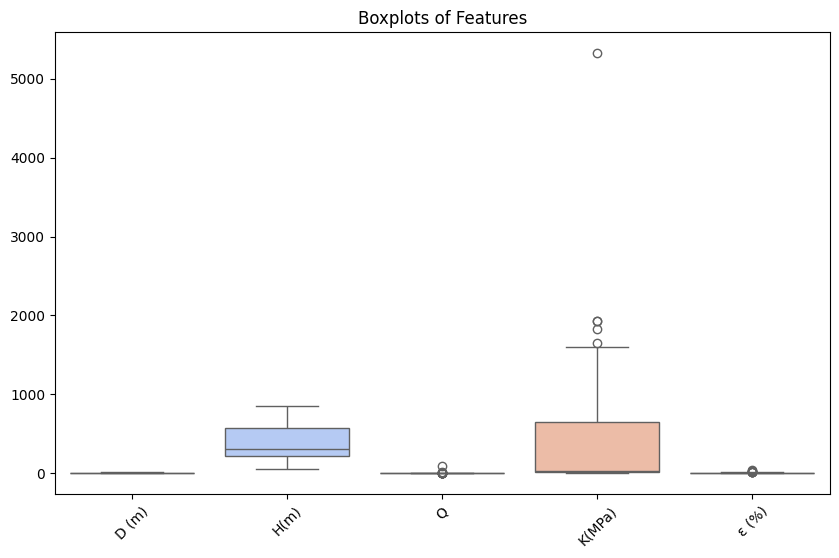

In [14]:
plt.figure(figsize=(10, 6) )
sns.boxplot(data=df.drop(columns=['Class']), palette='coolwarm')
plt.title('Boxplots of Features')
plt.xticks(rotation=45)
plt.show()

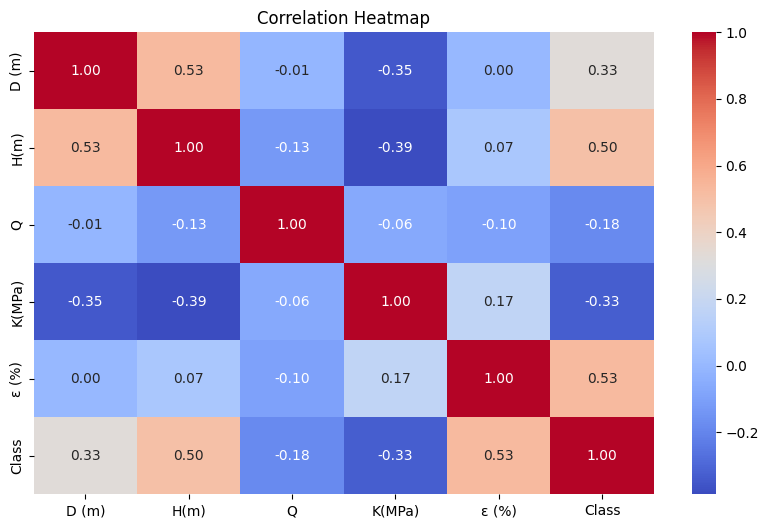

In [15]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Heatmap')
plt.show()

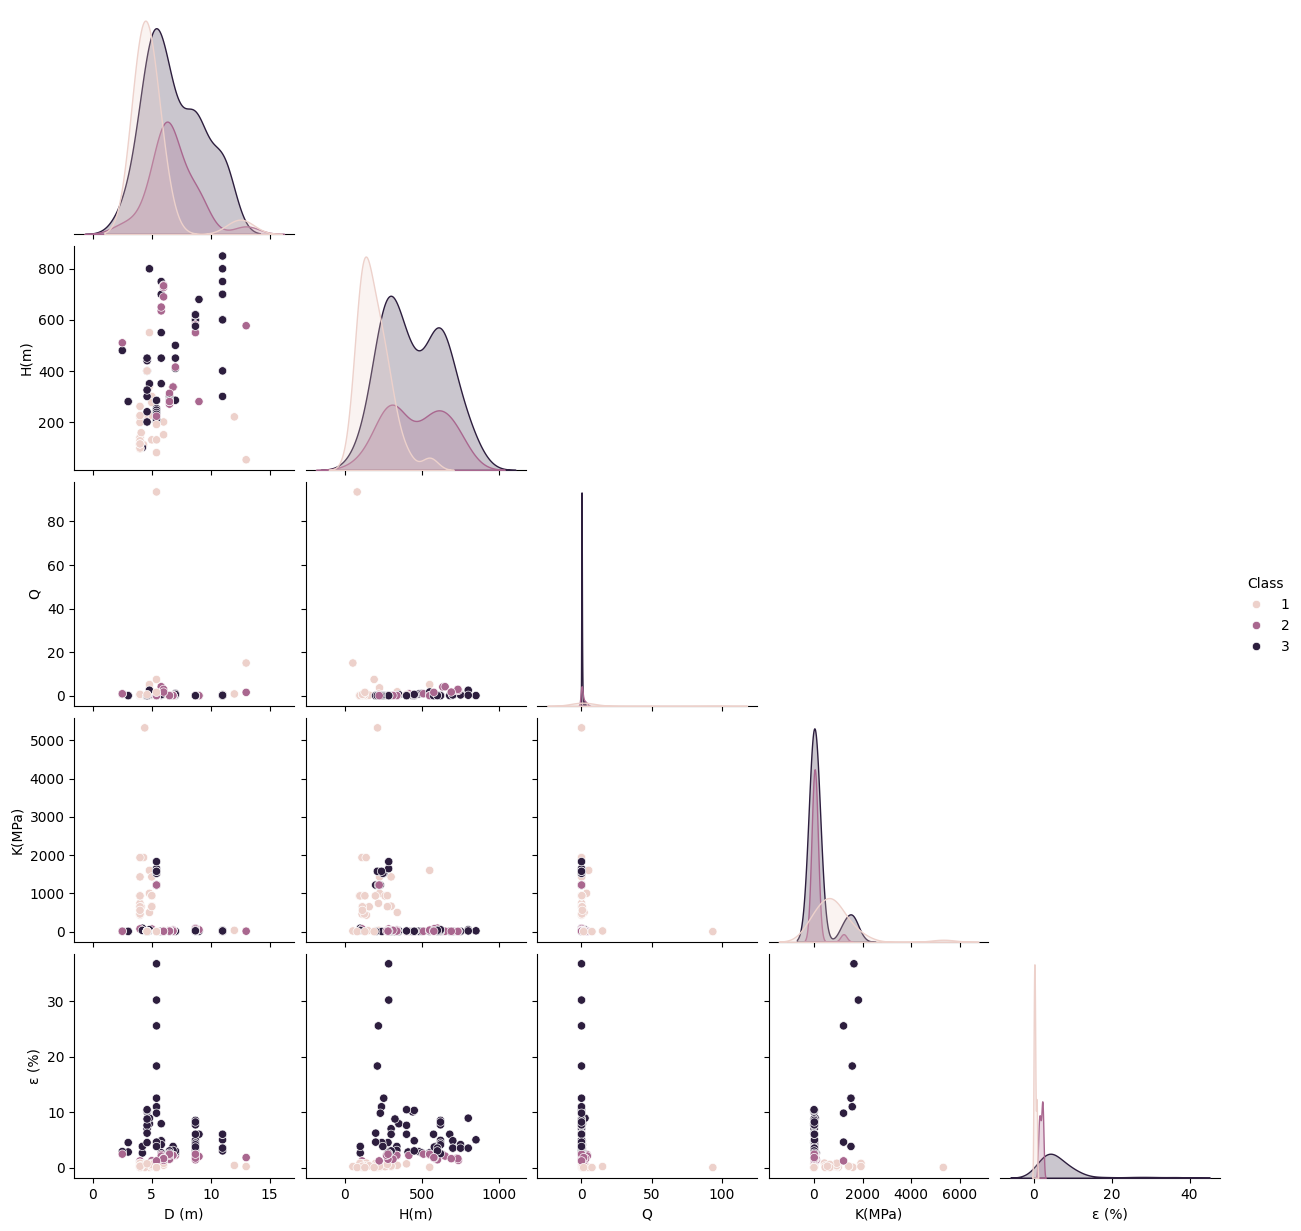

In [16]:
sns.pairplot(df, hue='Class', diag_kind='kde',corner = True)

In [4]:
X = df[["D (m)", "H(m)", "Q", "K(MPa)"]]
y = df["Class"]

## 5. Feature Engineering and Train-Test Split

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [29]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("Original training data shape:", X_train.shape)
print("SMOTE balanced training data shape:", X_train_smote.shape)
print("Original class distribution:\n", y_train.value_counts().sort_index())
print("SMOTE balanced class distribution:\n", y_train_smote.value_counts().sort_index())

Original training data shape: (93, 4)
SMOTE balanced training data shape: (141, 4)
Original class distribution:
 Class
1    29
2    17
3    47
Name: count, dtype: int64
SMOTE balanced class distribution:
 Class
1    47
2    47
3    47
Name: count, dtype: int64


## 6. Handle Class Imbalance with SMOTE

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import numpy as np
# Scale data first
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

param_dist = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

random_search = RandomizedSearchCV(SVC(class_weight='balanced', random_state=42), 
                                   param_dist, 
                                   n_iter=30,  # Test 30 random combinations
                                   cv=5, 
                                   scoring='balanced_accuracy',
                                   n_jobs=-1,
                                   verbose=1,
                                   random_state=42)

print("Starting randomized hyperparameter search...")
random_search.fit(X_train_smote_scaled, y_train_smote)

print(f"\nBest parameters: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_:.4f}")


best_model = random_search.best_estimator_

Starting randomized hyperparameter search...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best parameters: {'kernel': 'rbf', 'gamma': 1, 'C': 100}
Best cross-validation score: 0.8511


## 7. Hyperparameter Tuning with RandomizedSearchCV

In [31]:
# Fit final model with best params (probability enabled for ROC/PR curves)
best_params = random_search.best_params_
final_model = SVC(
    **best_params,
    class_weight='balanced',
    probability=True,
    random_state=42
)
final_model.fit(X_train_smote_scaled, y_train_smote)
print("Trained final_model with best params:", best_params)

Trained final_model with best params: {'kernel': 'rbf', 'gamma': 1, 'C': 100}


## 8. Train Final Model with Best Parameters

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, accuracy_score

y_pred = final_model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7083333333333334
Balanced Accuracy: 0.7765567765567766
Confusion Matrix:
 [[4 0 0]
 [0 5 2]
 [0 5 8]]
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
           2       0.50      0.71      0.59         7
           3       0.80      0.62      0.70        13

    accuracy                           0.71        24
   macro avg       0.77      0.78      0.76        24
weighted avg       0.75      0.71      0.72        24



## 9. Model Evaluation - Basic Metrics

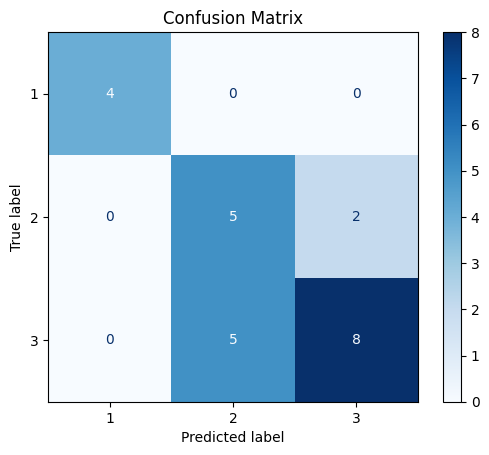

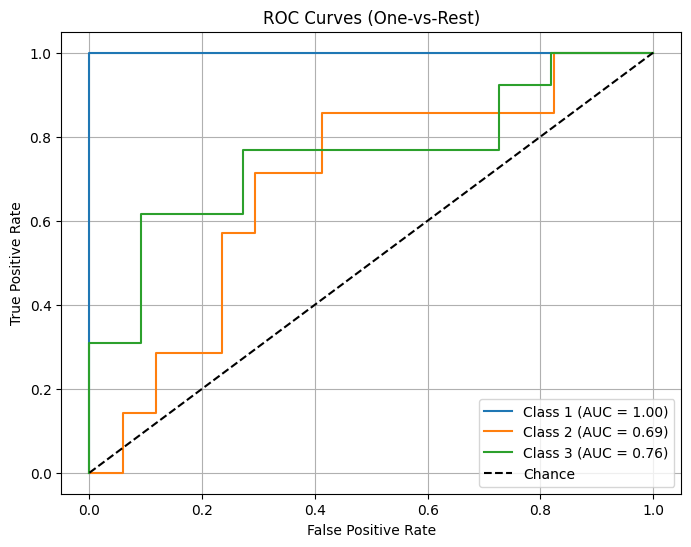

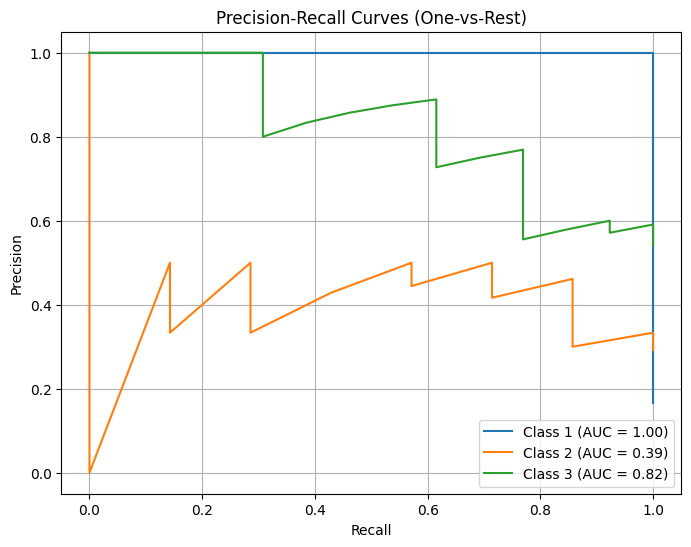

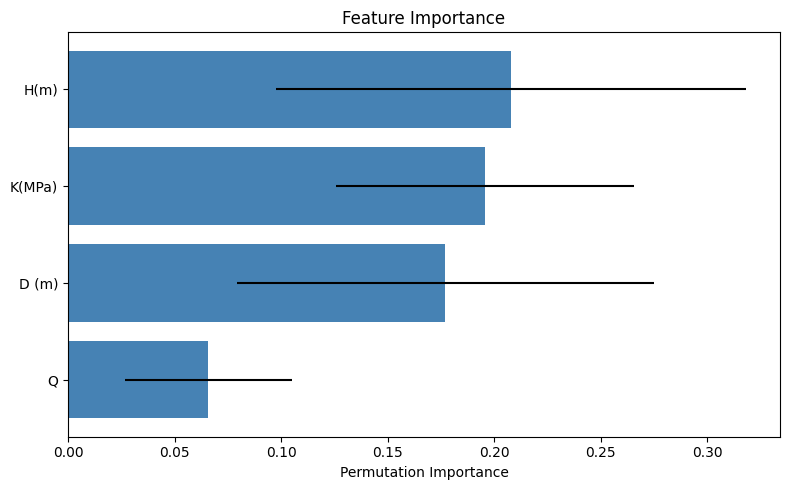

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    precision_recall_curve,
    PrecisionRecallDisplay,
)
from sklearn.preprocessing import label_binarize
from sklearn.inspection import permutation_importance

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Prepare data for multi-class ROC/PR
classes = final_model.classes_
y_test_bin = label_binarize(y_test, classes=classes)
scores = final_model.decision_function(X_test_scaled)

# ROC curves (one-vs-rest)
plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {cls} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall curves
plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], scores[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"Class {cls} (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (One-vs-Rest)")
plt.legend()
plt.grid(True)
plt.show()

# Permutation feature importance on test set
feature_names = X.columns
perm = permutation_importance(
    final_model,
    X_test_scaled,
    y_test,
    n_repeats=20,
    random_state=42,
    scoring='balanced_accuracy'
)
mean_importance = perm.importances_mean
std_importance = perm.importances_std
idx = np.argsort(mean_importance)

plt.figure(figsize=(8, 5))
plt.barh(np.array(feature_names)[idx], mean_importance[idx], xerr=std_importance[idx], color="steelblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

## 10. Advanced Visualizations

### 10.1 Confusion Matrix, ROC Curves, Precision-Recall Curves, and Feature Importance

Macro/Micro AUC summary:
           Metric     Score
0  ROC AUC macro  0.838573
1  ROC AUC micro  0.860243
2   PR AUC macro  0.761850
3   PR AUC micro  0.747117


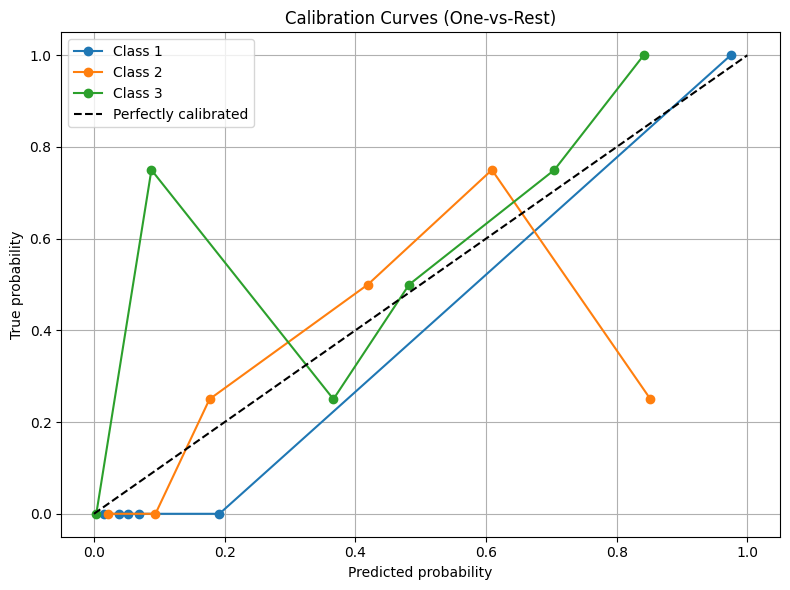

In [37]:
# Additional summary plots and metrics
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.calibration import calibration_curve

probs = final_model.predict_proba(X_test_scaled)
classes = final_model.classes_
y_test_bin = label_binarize(y_test, classes=classes)

# Macro/micro AUC and PR-AUC
roc_macro = roc_auc_score(y_test_bin, probs, average="macro", multi_class="ovr")
roc_micro = roc_auc_score(y_test_bin, probs, average="micro", multi_class="ovr")
pr_macro = average_precision_score(y_test_bin, probs, average="macro")
pr_micro = average_precision_score(y_test_bin, probs, average="micro")

summary = pd.DataFrame(
    {
        "Metric": ["ROC AUC macro", "ROC AUC micro", "PR AUC macro", "PR AUC micro"],
        "Score": [roc_macro, roc_micro, pr_macro, pr_micro],
    }
)
print("Macro/Micro AUC summary:\n", summary)

# Calibration curves (one-vs-rest probabilities)
plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    prob_true, prob_pred = calibration_curve(y_test_bin[:, i], probs[:, i], n_bins=6, strategy="quantile")
    plt.plot(prob_pred, prob_true, marker="o", label=f"Class {cls}")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Predicted probability")
plt.ylabel("True probability")
plt.title("Calibration Curves (One-vs-Rest)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 10.2 Macro/Micro AUC Summary and Calibration Curves

<Axes: title={'center': 'Feature Importance'}>

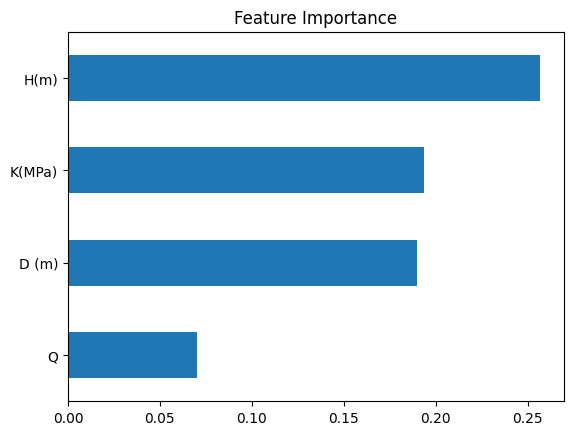

In [36]:
from sklearn.inspection import permutation_importance

r = permutation_importance(
    best_model,
    X_test_scaled,
    y_test,
    n_repeats=30,
    random_state=42,
    scoring="balanced_accuracy"
)

importances = pd.Series(r.importances_mean, index=X.columns) 
importances.sort_values().plot.barh(title="Feature Importance")


In [27]:
import joblib

joblib.dump(best_model, "svm_squeezing_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

## 11. Summary and Conclusions

### Key Results:
- **Final Accuracy:** 70.8%
- **Balanced Accuracy:** 77.7%
- **ROC AUC (Macro):** 83.9%
- **ROC AUC (Micro):** 86.0%

### Optimal Hyperparameters:
- Kernel: RBF
- C: 100
- Gamma: 1

### Feature Importance (Highest to Lowest):
1. H(m) - Height
2. K(MPa) - Stress constant
3. D(m) - Diameter
4. Q - Flow parameter

### Key Insights:
- Class 1 achieves perfect classification (100% precision and recall)
- Class 2 remains the most challenging (lowest F1-score)
- SMOTE successfully balanced the training data from imbalanced (29, 17, 47) to balanced (47, 47, 47)
- RandomizedSearchCV provided efficient hyperparameter optimization